In [1]:
import numpy as np
import igraph as ig
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
import scipy.stats as st
import pickle

sns.set()

In [2]:
with open('data/pickles/complete_df.pickle','rb') as f:
    df = pickle.load(f)

Costruisco per i primi 15 giorni una la rete aggiungengio un giorno alla volta, partendo da 3 giorni, e confronto la densità o la dimensone della componente connessa

In [3]:
df['day_count'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [4]:
def build_graph(data_retweet, fini_day,init_day = 0):
    sub_set = data_retweet[(data_retweet.day_count >= init_day)&(data_retweet.day_count < fini_day)]
    db_for_network = sub_set.groupby(['retweeted_status.user.id','user.id'], as_index=False).count()
    db_for_network = db_for_network[db_for_network.weight > 1]#.astype(int)
    return ig.Graph.TupleList(db_for_network[['retweeted_status.user.id','user.id','weight',]].itertuples(index=False), directed=True, weights=True)

In [5]:
graphs_first_15  = []
for day in range(3,16):
    graphs_first_15.append(build_graph(df, day)) 

da ognuno misuro la dimensione della più gande componente connessa

In [6]:
giant_connected_component_dimension = []
relative_gcc_dimension = []
for g in graphs_first_15:
    cl = g.components(mode='WEAK') #STRONG means that each pair of vertex must be reachable from each other
    giant_connected_component_dimension.append(len(cl.giant().vs))
    relative_gcc_dimension.append(len(cl.giant().vs)/len(g.vs))

faccio lo stesso per gli ultimi 15 giorni

In [15]:
graphs_last_15  = []
for day in range(18,31):
    graphs_last_15.append(build_graph(df, day, init_day=15))
    
giant_connected_component_dimension_bis = []
relative_gcc_dimension_bis = []
for g in graphs_last_15:
    cl = g.components(mode='WEAK') 
    giant_connected_component_dimension_bis.append(len(cl.giant().vs))
    relative_gcc_dimension_bis.append(len(cl.giant().vs)/len(g.vs))

calcolo anche le densità

In [20]:
density_first = [g.density() for g in graphs_first_15]
density_last = [g.density() for g in graphs_last_15]

In [40]:
len(giant_connected_component_dimension)

13

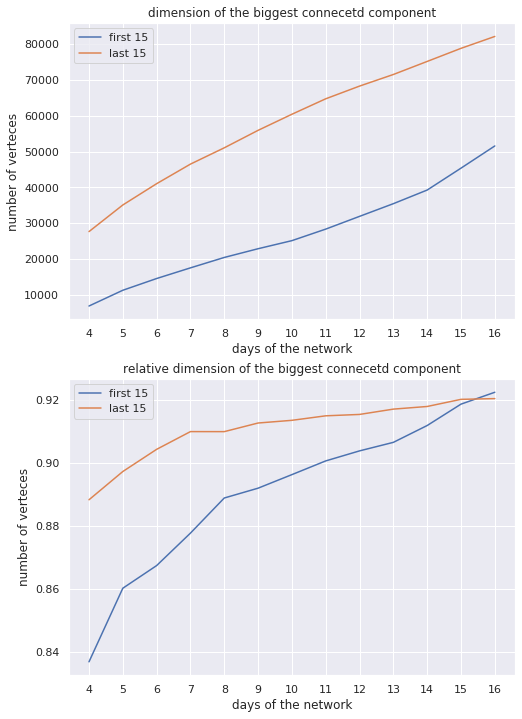

In [42]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (8,12))
ax1.plot(giant_connected_component_dimension, label='first 15')
ax1.plot(giant_connected_component_dimension_bis,label='last 15')
ax1.set_title('dimension of the biggest connecetd component')
ax1.set_ylabel('number of verteces')
ax1.set_xlabel('days of the network')
ax1.set_xticks(range(13))
ax1.set_xticklabels(range(4,17))
ax1.legend()
ax2.plot(relative_gcc_dimension,label='first 15')
ax2.plot(relative_gcc_dimension_bis, label='last 15')
ax2.set_title('relative dimension of the biggest connecetd component')
ax2.set_ylabel('number of verteces')
ax2.set_xlabel('days of the network')
ax2.set_xticks(range(13))
ax2.set_xticklabels(range(4,17))
ax2.legend()

in entrambi i periodi la componente connessa tende a coprire tutto il network mano a mano che si aggiungono giorni, quindi nodi e link, al network. Nel secondo periodo appare comunque fin da subito più grande, sembra coprire tutto la maggiorparte del network in meno tempo.

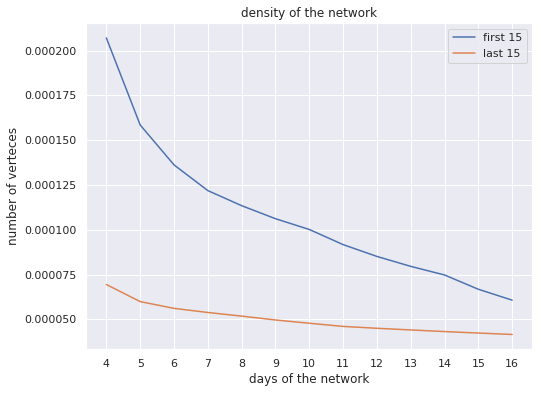

In [46]:
fig,ax = plt.subplots(1,1, figsize= (8,6))
ax.plot(density_first, label='first 15')
ax.plot(density_last, label = 'last 15')
ax.set_title('density of the network')
ax.set_ylabel('number of verteces')
ax.set_xlabel('days of the network')
ax.set_xticks(range(13))
ax.set_xticklabels(range(4,17))
ax.legend()

la densità tende a diminuire, il che probabilmente significa che aumentano i nuovi nodi (quindi utenti che retweetano) e quindi aumentano i possibili collegamenti della rete ->  n*(n-1) / 2

Cosa accade se utilizzo il mode=STRONG per la ricerca della componente conessa, ovvero ogni coppia di utenti deve essere raggiungibile partendo da ciascuno dei due

In [97]:
gcc_strong = [[],[]]
rel_gcc_strong = [[],[]]
for g in graphs_first_15:
    cl = g.components(mode='STRONG') 
    gcc_strong[0].append(cl.giant().vcount())
    rel_gcc_strong[0].append(len(cl.giant().vs)/g.vcount())

for g in graphs_last_15:
    cl = g.components(mode='STRONG') 
    gcc_strong[1].append(len(cl.giant().vs))
    rel_gcc_strong[1].append(len(cl.giant().vs)/len(g.vs))

In [98]:
gcc_strong

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

Non sono presenti componenti di tal tipo

In [207]:
g_tot = build_graph(df,30)

In [208]:
g_tot.density()

3.775366155024702e-05

In [211]:
g_tot.components(mode='WEAK').giant().vcount()/g_tot.vcount()  #relative size of the giant component

0.9340289293094212

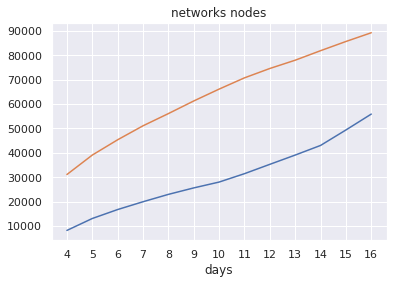

In [219]:
plt.title('networks nodes')
plt.plot([g.vcount() for g in graphs_first_15])
plt.plot([g.vcount() for g in graphs_last_15])
plt.xticks(range(13),range(4,17))
plt.xlabel('days')
plt.show()

osservo che nel secondo priodo parto gia da un network con più di 3 volte quello del primo periodo, provo a equilibrare un poco i dati cosi da avere due quantità più confrontabili

non ho trovato un metodo di unione dei grafici per risparmiare tempo invecedi ricalcolarli ogni volta dal giorno 0, poichè non sembra ci sia la possibilità di sommare i pesi dei link durante l'unione

In [220]:
graphs  = {'first' :[],'last':[]}
for day in range(5,18):
    graphs['first'].append(build_graph(df, day, init_day=0))

for day in range(18,31):
    graphs['last'].append(build_graph(df, day, init_day=17))
     
gcc = {'first' :[],'last':[]}
rel_gcc = {'first' :[],'last':[]}

for g in graphs['first']:
    cl = g.components(mode='WEAK') 
    gcc['first'].append(cl.giant().vcount())
    rel_gcc['first'].append(cl.giant().vcount()/g.vcount())
for g in graphs['last']:
    cl = g.components(mode='WEAK') 
    gcc['last'].append(cl.giant().vcount())
    rel_gcc['last'].append(cl.giant().vcount()/g.vcount())

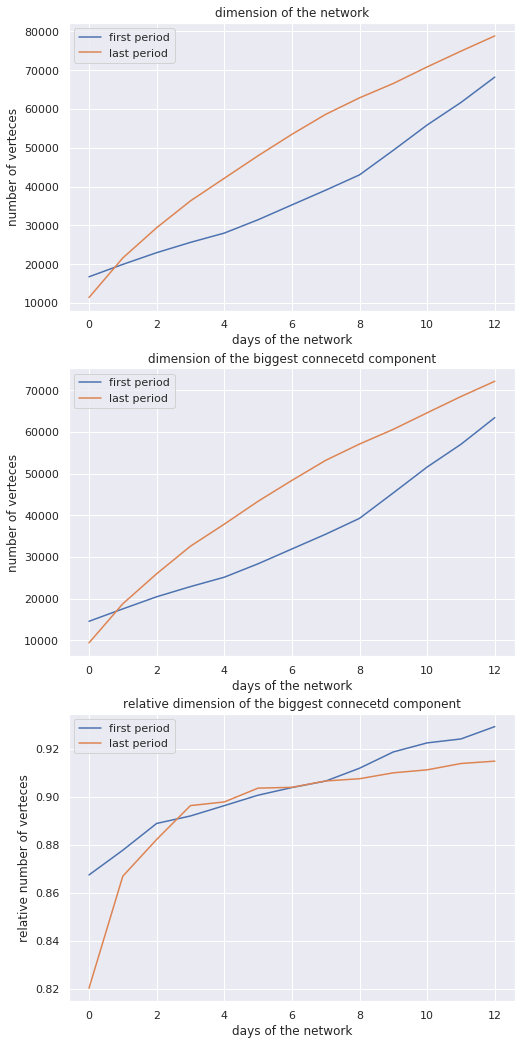

In [223]:
fig, (ax0, ax1,ax2) = plt.subplots(3,1,figsize = (8,18))
ax0.plot([g.vcount() for g in graphs['first']], label='first period')
ax0.plot([g.vcount() for g in graphs['last']],label='last period')
ax0.set_title('dimension of the network')
ax0.set_ylabel('number of verteces')
ax0.set_xlabel('days of the network')
#ax0.set_xticks(range(13))
#ax0.set_xticklabels(range(4,17))
ax0.legend()
ax1.plot(gcc['first'], label='first period')
ax1.plot(gcc['last'],label='last period')
ax1.set_title('dimension of the biggest connecetd component')
ax1.set_ylabel('number of verteces')
ax1.set_xlabel('days of the network')
#ax1.set_xticks(range(13))
#ax1.set_xticklabels(range(4,17))
ax1.legend()
ax2.plot(rel_gcc['first'],label='first period')
ax2.plot(rel_gcc['last'], label='last period')
ax2.set_title('relative dimension of the biggest connecetd component')
ax2.set_ylabel('relative number of verteces')
ax2.set_xlabel('days of the network')
#ax2.set_xticks(range(13))
#ax2.set_xticklabels(range(4,17))
ax2.legend()

in efetti sembra che le grandezze crescano più o meno allo stesso modo, per scrupolosità costruisco i network partendo dallo stesso numero di dati e aggiungendone la stessa quantità di volta in volta sia per il primo che per il secondo periodo

In [224]:
len(df) #numero totali di rewteet

4783720

In [269]:
df_half = df.copy() # copia da dividere in due, per il pmo e il secondo periodo

In [270]:
len(df_half)//2

2391860

In [271]:
df_half1 = df_half.iloc[:len(df_half)//2]
df_half2 = df_half.iloc[len(df_half)//2:]

In [272]:
len(df_half1) == len(df_half2)

True

In [273]:
print((len(df_half)//2)//15) # suddivisione in 15 gruppi
print((len(df_half)//2)%15) # resto della suddivisione

159457
5


In [274]:
initial_set = ((len(df_half)//2)//15)*5 + (len(df_half)//2)%15
new_lines = (len(df_half)//2)//15

In [266]:
def build_graph_iter(data,it_number):
    global initial_set
    global new_lines
    data = data.iloc[:initial_set+it_number*new_lines]
    data = data.groupby(['retweeted_status.user.id','user.id'], as_index=False).count()
    data = data[data.weight > 1]
    return ig.Graph.TupleList(data[['retweeted_status.user.id','user.id','weight',]].itertuples(index=False), directed=True, weights=True)
    

In [267]:
graphs  = {'first' :[],'last':[]}
for it in range(10):
    graphs['first'].append(build_graph_iter(df_half1,it))

for it in range(10):
    graphs['last'].append(build_graph_iter(df_half2,it))
     
gcc = {'first' :[],'last':[]}
rel_gcc = {'first' :[],'last':[]}

for g in graphs['first']:
    cl = g.components(mode='WEAK') 
    gcc['first'].append(cl.giant().vcount())
    rel_gcc['first'].append(cl.giant().vcount()/g.vcount())
for g in graphs['last']:
    cl = g.components(mode='WEAK') 
    gcc['last'].append(cl.giant().vcount())
    rel_gcc['last'].append(cl.giant().vcount()/g.vcount())

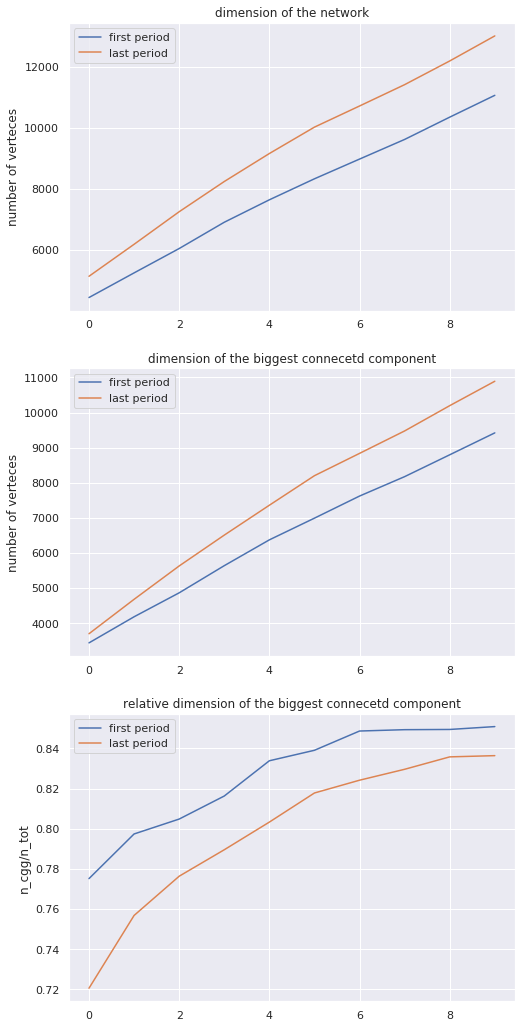

In [281]:
fig, (ax0, ax1,ax2) = plt.subplots(3,1,figsize = (8,18))
ax0.plot([g.vcount() for g in graphs['first']], label='first period')
ax0.plot([g.vcount() for g in graphs['last']],label='last period')
ax0.set_title('dimension of the network')
ax0.set_ylabel('number of verteces')
#ax0.set_xlabel('days of the network')
#ax0.set_xticks(range(13))
#ax0.set_xticklabels(range(4,17))
ax0.legend()
ax1.plot(gcc['first'], label='first period')
ax1.plot(gcc['last'],label='last period')
ax1.set_title('dimension of the biggest connecetd component')
ax1.set_ylabel('number of verteces')
#ax1.set_xlabel('days of the network')
#ax1.set_xticks(range(13))
#ax1.set_xticklabels(range(4,17))
ax1.legend()
ax2.plot(rel_gcc['first'],label='first period')
ax2.plot(rel_gcc['last'], label='last period')
ax2.set_title('relative dimension of the biggest connecetd component')
ax2.set_ylabel('n_cgg/n_tot')
#ax2.set_xlabel('days of the network')
#ax2.set_xticks(range(13))
#ax2.set_xticklabels(range(4,17))
ax2.legend()

l'andamento appare simile in entrambi i casi, e soprattutto non sembra che la situazione esterna (pandemia) abbia cambiato prticolarmente la comunità di twitter

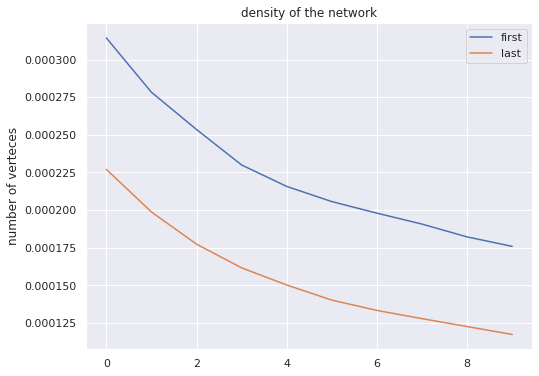

In [284]:
fig,ax = plt.subplots(1,1, figsize= (8,6))
ax.plot([g.density() for g in graphs['first']], label='first')
ax.plot([g.density() for g in graphs['last']], label = 'last')
ax.set_title('density of the network')
ax.set_ylabel('number of verteces')
ax.legend()

anche l'andamento della densità è analogo nei due periodi, con un piccolo scontamento abbastanza costante

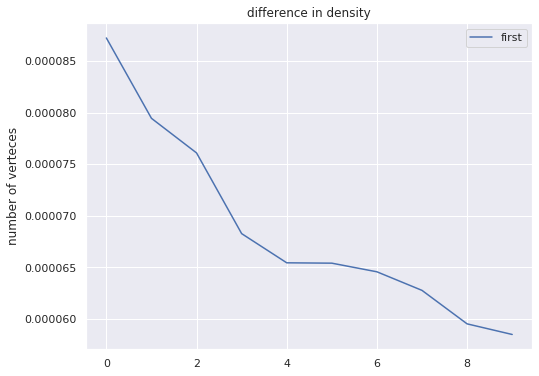

In [285]:
fig,ax = plt.subplots(1,1, figsize= (8,6))
ax.plot([g.density() - j.density() for g,j in zip(graphs['first'],graphs['last'])], label='first')
ax.set_title('difference in density')
ax.set_ylabel('number of verteces')
ax.legend()